# Setup

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt


In [201]:
from datetime import datetime

def toDate(ts):
    return datetime.fromtimestamp(float(ts)).date()

np.random.seed(7)

# Load the data

In [143]:
df = pd.read_csv("~/data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv", parse_dates=True, date_parser=toDate, index_col="Timestamp")
df.index.names = ["Date"]
df['Volume'] = pd.to_numeric(df['Volume_(Currency)'])

df.shape


1304.0


(1819074, 8)

# Preprocess the data

In [146]:
historical_prices = df.resample('1D').agg({'Open': 'first', 
                                 'High': 'max', 
                                 'Low': 'min', 
                                 'Close': 'last',
                                 'Volume': 'sum'}).dropna()
historical_prices = historical_prices[['Close', 'Volume']]

number_of_days = historical_prices.shape[0]
print(number_of_days)

historical_prices.shape

1271


(1271, 2)

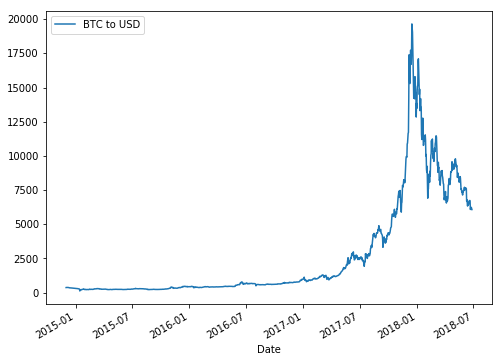

In [147]:
historical_prices.reset_index().plot(x="Date", y="Close", figsize=(8, 6), label="BTC to USD")

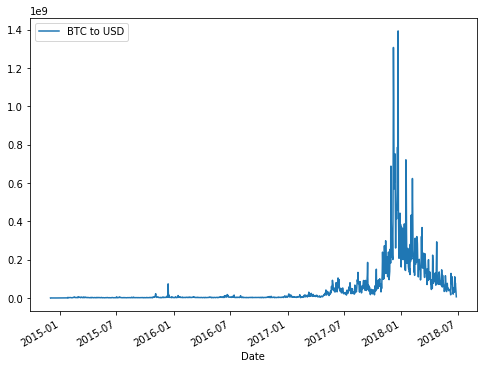

In [148]:
historical_prices.reset_index().plot(x="Date", y="Volume", figsize=(8, 6), label="BTC to USD")

# Split the dataset into training and testing set

In [177]:
from sklearn.model_selection import train_test_split

test_split_point = int(number_of_days * 0.8)
train = historical_prices[:test_split_point]
test = historical_prices[test_split_point:]

In [178]:
train.shape

(1016, 2)

In [179]:
test.shape

(255, 2)

# Train model

In [269]:
train = train.sort_values(by='Date')
test = test.sort_values(by='Date')

In [270]:
window_len = 10
LSTM_training_inputs = []
norm_cols = ["Close", "Volume"]

for i in range(len(train)-window_len):
    temp_set = train[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs = (train['Close'][window_len:].values/train['Close'][:-window_len].values)-1

In [271]:
LSTM_test_inputs = []
for i in range(len(test)-window_len):
    temp_set = test[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = (test['Close'][window_len:].values/test['Close'][:-window_len].values)-1

In [272]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [273]:
model = Sequential()

model.add(LSTM(20, input_shape=(LSTM_training_inputs.shape[1], LSTM_training_inputs.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.add(Activation("linear"))

model.compile(loss="mae", optimizer="adam")

In [274]:
history = model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=20, batch_size=1, verbose=2, shuffle=True)

Epoch 1/20
 - 14s - loss: 0.0566
Epoch 2/20
 - 13s - loss: 0.0417
Epoch 3/20
 - 14s - loss: 0.0378
Epoch 4/20
 - 14s - loss: 0.0367
Epoch 5/20
 - 15s - loss: 0.0335
Epoch 6/20
 - 14s - loss: 0.0322
Epoch 7/20
 - 14s - loss: 0.0318
Epoch 8/20
 - 14s - loss: 0.0340
Epoch 9/20
 - 14s - loss: 0.0340
Epoch 10/20
 - 14s - loss: 0.0343
Epoch 11/20
 - 14s - loss: 0.0313
Epoch 12/20
 - 15s - loss: 0.0298
Epoch 13/20
 - 14s - loss: 0.0307
Epoch 14/20
 - 14s - loss: 0.0302
Epoch 15/20
 - 13s - loss: 0.0292
Epoch 16/20
 - 14s - loss: 0.0317
Epoch 17/20
 - 14s - loss: 0.0317
Epoch 18/20
 - 13s - loss: 0.0293
Epoch 19/20
 - 14s - loss: 0.0302
Epoch 20/20
 - 13s - loss: 0.0286


In [275]:
predicted_values = model.predict(LSTM_test_inputs)

In [276]:
mae = np.mean(np.abs((np.transpose(predicted_values) + 1)-(test['Close'].values[window_len:])/(test['Close'].values[:-window_len]))) 

mae

0.04320114463000481

In [278]:
predicted = (np.transpose(predicted_values) + 1)

In [279]:
actual = (test['Close'].values[window_len:])/(test['Close'].values[:-window_len])

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:504: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


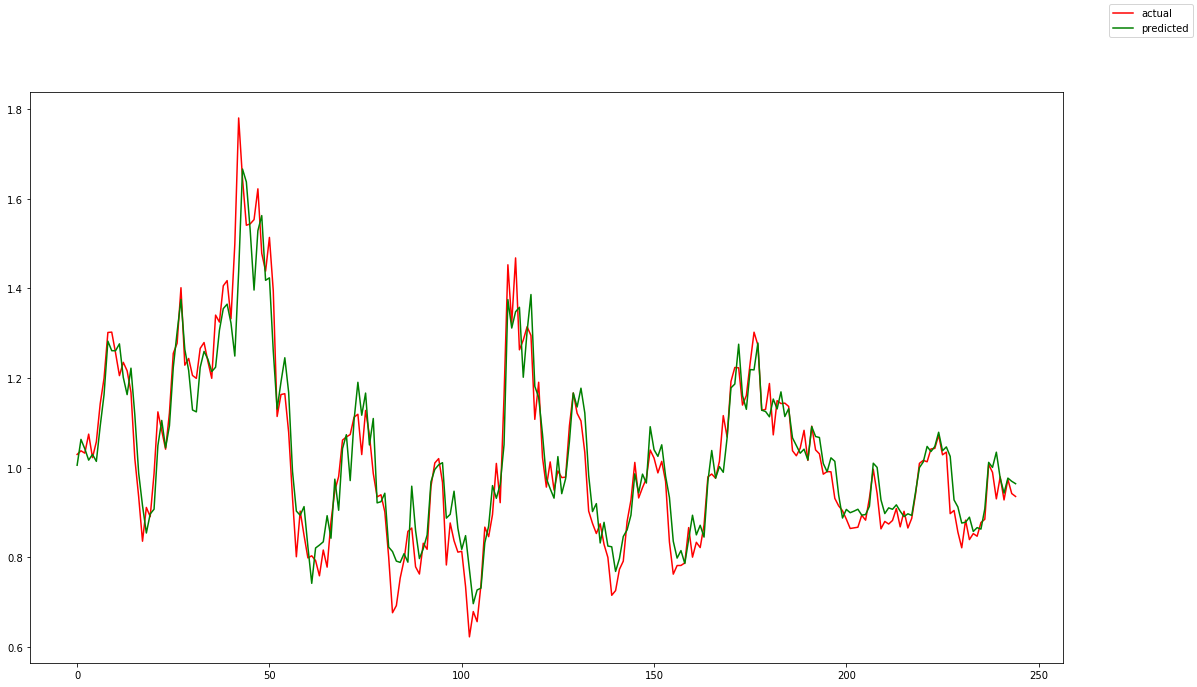

In [280]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
ax1.plot(actual, label="actual", color="red")
ax1.plot(predicted[0], label="predicted", color="green")
fig.legend(loc="best")
plt.show()

In [281]:
rmae = np.sqrt(((predicted-actual) ** 2).mean())

rmae

0.05980303704235407